## AGCDv1 max temp to LDsss (1950/51 to 1978/79, 1979/80 to 2015/16 & 1950/51 to 2015/16)

In [8]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
from pathlib import Path

%matplotlib inline

In [3]:
# Load NDJF tmax average netcdf (calculated in AGCD_maxtemp_LDsss_correlation_1900-2016.ipynb)
ds_tmax = xr.open_dataset('/g/data1a/v45/du2523/Monthly_calcs/AGCDv1_NDJF_tmax_mean_1910-2016.nc')
ds_tmax

<xarray.Dataset>
Dimensions:  (time: 106, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1911-02-14T12:00:00 1912-02-15 ... 2016-02-15
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    tmax     (time, lat, lon) float64 ...

In [4]:
# Load LDsss dataset (1900 - 2016)
ds_icecore = xr.open_dataset('/g/data1a/v45/du2523/Monthly_calcs/LDsss_DJFM_1910-11_to_2015-16_AGCD_tmax_grid.nc')
ds_icecore

<xarray.Dataset>
Dimensions:  (time: 106, lat: 691, lon: 886)
Coordinates:
  * time     (time) datetime64[ns] 1911-02-14T12:00:00 1912-02-15 ... 2016-02-15
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Data variables:
    LDsss    (time, lat, lon) float64 ...

In [43]:
#slice datasets to be the same length
#change start & end time to modify periods (e.g. 1950/51 to 1978/79, 1979/80 to 2015/16 & 1950/51 to 2015/16)
time_start = '1980'
time_end = '2016'
period = '1979-80_2015-16'

LDsss = ds_icecore.LDsss.sel(time = slice(time_start,time_end))
tmax = ds_tmax.tmax.sel(time = slice(time_start,time_end))

In [44]:
LDsss

<xarray.DataArray 'LDsss' (time: 37, lat: 691, lon: 886)>
[22652362 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1980-02-15 1981-02-14T12:00:00 ... 2016-02-15
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    units:    logCl

In [45]:
tmax

<xarray.DataArray 'tmax' (time: 37, lat: 691, lon: 886)>
[22652362 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1980-02-15 1981-02-14T12:00:00 ... 2016-02-15
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:               time: maximum time: mean (interval : 1 day)
    units:                      degrees_Celsius
    analysis_version_number:    2.0
    long_name:                  Daily maximum air temperature
    standard_name:              air_temperature
    frequency:                  monthly
    length_scale_for_analysis:  350.0
    end_offset:                 24
    grid_mapping:               crs
    coverage_content_type:      physicalMeasurement
    valid_range:                [-100.  100.]

## Detrend

In [46]:
#Detrend function

def detrend_dim(da, dim, deg = 1):
    #detrend along a single dimension
    p = da.polyfit(dim = dim, deg = deg)
    fit = xr.polyval(da[dim],p.polyfit_coefficients)
    return da - fit

In [47]:
dtmax = detrend_dim(tmax,"time",1)
dLDsss = detrend_dim(LDsss,"time",1)

## Correlation

In [48]:
#correlation on detrended datasets
dcorr = xr.corr(dLDsss,dtmax, dim = "time")

In [49]:
maxcorr = dcorr.max().values
mincorr = dcorr.min().values
mincorr, maxcorr

(array(-0.58622377), array(0.28626326))

In [50]:
#calculate signficance of correlation 
from scipy import stats
#degrees of freedom (sample size - number of parameters)
ntime = dLDsss.shape[0]
sample_size = ntime
degF = sample_size - 2

dsig = xr.DataArray(data = dcorr.values*np.sqrt((ntime-2)/1-np.square(dcorr.values)),
                   dims = ["lat","lon"],
                   coords = [dcorr.lat,dcorr.lon])
t90 = stats.t.ppf(1-0.05, ntime-2)
t95 = stats.t.ppf(1-0.025, ntime-2)   

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


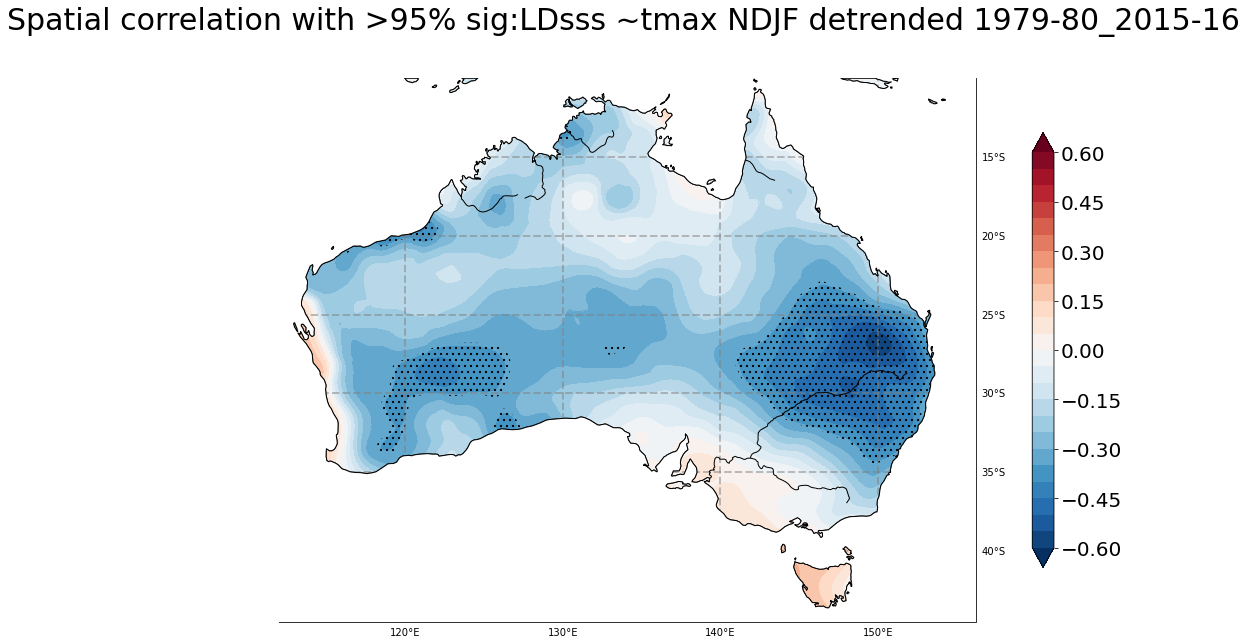

In [51]:
#Plot correlation results with significance shaded

output = '/g/data/v45/du2523/correlation_plots/'

fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())

levels = np.arange(-0.6,0.65,0.05)
var = 'LDsss'
period = period
ID = 'tmax_corr_NDJF_detrend_sig95'
region = 'Aus'

#either corr or dcorr

cp = dcorr.plot.contourf(ax = ax,
                        levels = levels,
                        extend = 'both',
                        cmap = 'RdBu_r',
                        transform = ccrs.PlateCarree(),
                        add_colorbar = False)

cb = fig.colorbar(cp, ax = ax, shrink = 0.8)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

#either sig or dsig                      
sig_hatch = dsig.plot.contourf(ax = ax,
                 levels = [-1*t95,-1*t90,t90,t95],
                 colors = 'none',
                 hatches = ['..',None,None,None,'..'],
                 extend = 'both',
                 add_colorbar = False,
                 transform = ccrs.PlateCarree())
    
ax.coastlines()
ax.add_feature(cart.feature.OCEAN,zorder=100, edgecolor='k', facecolor = 'w')
ax.add_feature(cart.feature.RIVERS,zorder=100,edgecolor='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
    
fig.suptitle('Spatial correlation with >95% sig:'+ var + ' ~tmax NDJF detrended ' + period,fontsize = 30)
 
#save figure
fig.savefig(output + var + '_'+ ID +'_'+ period + '_' + region  +'.jpg')